In [35]:
import torch
import clip
from PIL import Image

In [36]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [41]:
def find_text_match(image, text_list):
    # given an image and a list of possible text matchs, find the best match
    image = preprocess(Image.open(image)).unsqueeze(0).to(device)
    text = clip.tokenize(text_list).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    res = dict(zip(text_list, probs[0] * 100))
    return res
    
# TODO
def find_image_match(text, image_list):
    # give a text and a list of possible image matchs, find the best match
    pass

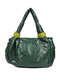

In [42]:
Image.open("a_bag.jpg")

In [43]:
find_text_match(image="a_bag.jpg", text_list=["a bag", "a hat", "a cat"])

{'a bag': 99.96662, 'a hat': 0.011180727, 'a cat': 0.02220167}

In [44]:
find_text_match(image="a_bag.jpg", text_list=["a green bag", "a deep green bag", "a bag", "a blue bag"])

{'a green bag': 17.222015,
 'a deep green bag': 82.64399,
 'a bag': 0.098632365,
 'a blue bag': 0.03536507}